#1. Business Problem
![customer sugmentation project](https://drive.google.com/uc?id=1-56RhdBPhhTZCY1aLf-RSg3kM9nMVLPC)




##1.1 Problem Context:
The client is a UK-based online retailer specializing in gifts for all occasions, with a significant portion of their customer base consisting of wholesalers. While most of their customers are from the UK, they also have a smaller segment of international customers. The retailer aims to improve its marketing strategies and service offerings by grouping international customers based on their historical purchase patterns.
##1.2 Issues with the Current Approach:
Currently, the retailer categorizes international customers by their country of origin. However, this approach presents several challenges:

A large number of countries results in many small, less meaningful customer groups.
Some countries have very few customers, making the groups too small to be actionable.
The current method does not differentiate between large and small customers based on their purchase behaviors.
##1.3 Problem Statement:
The retailer has engaged our services to develop customer segments through a data-driven approach. They have provided a dataset containing transaction-level purchase data. Our task is to build a clustering model that considers both overall sales patterns and the specific items purchased by each customer.

##1.4 Business Objectives and Constraints:
The objective is to identify distinct customer segments, enabling the retailer to offer more personalized services and conduct targeted marketing campaigns for their international customers.
#2. Machine Learning Problem

##2.1 Data Overview:
The dataset contains 35,116 records of international transactions spanning 37 countries, with the following features:

Invoice Information:
InvoiceNo: Unique identifier for each invoice
InvoiceDate: Date of the invoice
Item Information:
StockCode: Unique identifier for each item
Description: Description of the item
Quantity: Number of units per item per pack
UnitPrice: Price per unit in GBP
Customer Information:
CustomerID: Unique identifier for each customer
Country: Country of the customer
##2.2 Mapping the Business Problem to an ML Problem

###2.2.1 Type of ML Problem:
This is an unsupervised learning task aimed at segmenting customers based on their purchasing behaviors. Using transaction-level data, the goal is to create meaningful customer clusters that reflect their buying patterns.

#3. Exploratory Data Analysis


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## 3.1 Load the dataset

In [4]:
# load the international online transactions data (csv format)
df=pd.read_csv("int_online_tx.csv")
#checking the first 10 observations
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


here is some questions to consider :
* in the first 10 obvservations , how many diffrent customers are?
* how many different invoices aare there?
* given answers to the first two questions , how many unique purchases are shown ?
* technically , aren't these observations actually line-itmes within each transaction?
* do you expect customer level dataset to bw much smaller?


In [5]:
df.shape

(35116, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35116 entries, 0 to 35115
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    35116 non-null  int64  
 1   StockCode    35116 non-null  object 
 2   Description  35116 non-null  object 
 3   Quantity     35116 non-null  int64  
 4   InvoiceDate  35116 non-null  object 
 5   UnitPrice    35116 non-null  float64
 6   CustomerID   33698 non-null  float64
 7   Country      35116 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.1+ MB


here we can see that our dataset is a dataset for transactions for wholeslaers with many informations related to different aspects of the process


<Axes: xlabel='count', ylabel='Country'>

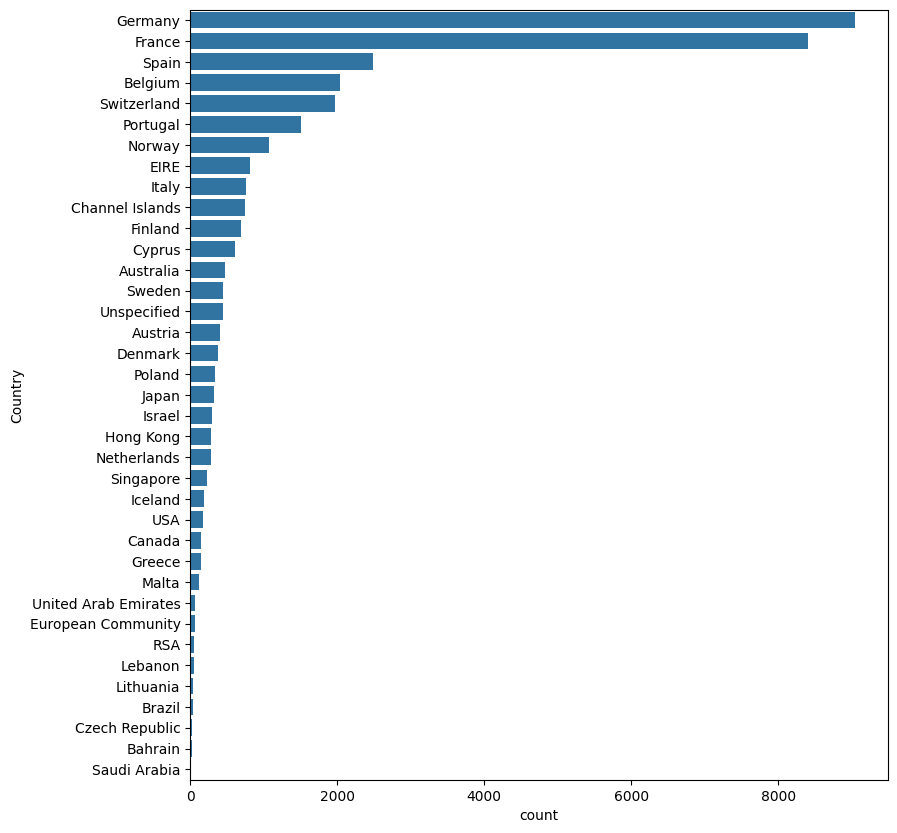

In [7]:
plt.figure(figsize=(9,10))
sns.countplot(df, y='Country', order=df['Country'].value_counts().index)

there are so many sparse classes.Countries like lithuania, brazil , and even USA have a tiny number of transactions.
####note:
this is a transaction/line-item level the number of customers for each country is  even smaller because each customer has multiple transactions! so therefore its plain to see that clustering by country is not very efficient

# 4. Transaction-level Cleaning
Before we aggregate to the customer level, we need to tidy up a few things at the transaction level.
* Technically, this is the **"line-item" level** because one invoice (a.k.a. transaction) spans multiple rows. However, we'll just refer to it as the "transaction level" for simplicity.
* Also the terms **"aggegrating up"** and **"rolling up"** are used interchangeability.

First, we need to check for any missing data before rolling up. If we don't, we might get confusing results later because rolling up to a higher level can sometimes hide the fact that data was missing at the lower level.

Display the number of missing observations for each feature.

In [8]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,1418
Country,0


'CustomerID' has missing observations
* Should we **label them as missing** (as for categorical features) or should we **flag and fill** them (as for numeric features)?
* We should do neither. Instead, we simply need to drop transactions with missing CustomerID.
* Think back to the project scope: We are trying to cluster customers in order to provide more tailored service!
* That means transactions with missing 'CustomerID' are actually pointless to keep.
* In other words, they should be considered "unwanted observations" instead of "missing data!".

Drop observations with missing customer ID's.

In [9]:
df=df[df.CustomerID.notnull()]

next just for clarity we should convert them into integers instead of floats so they dont mix up with other numeric features

In [10]:
df['CustomerID']=df.CustomerID.astype(int)
df.CustomerID.head()

,CustomerID
0,12583
1,12583
2,12583
3,12583
4,12583


There's one feature we need to create at the transaction level.

Look back at the first 10 observations you displayed earlier.
* Are there any features that tell you how much money the customer spent on each transaction?
* Well, we have 'Quantity' and 'UnitPrice', but those are for individual units, not for the transaction.
* We need to multiply them together to get the Sales amount for that transaction.

In [11]:
df['sales']=df.Quantity * df.UnitPrice
df.sales.head()

,sales
0,90.0
1,90.0
2,45.0
3,10.2
4,15.6


Before moving on, save your cleaned transaction-level data as **cleaned_transactions.csv.**

In [12]:
df.to_csv('/content/cleaned_transactions.csv',index=None)

# 5. Customer-level feature engineering
Now that we have a cleaned transaction-level dataset, it's time to **roll it up** (aggregate up) to the customer level, which we'll feed into our machine learning algorithms later.

We want 1 customer per row, and we want the features to represent information such as:
* Number of unique purchases by the customer
* Average cart value for the customer
* Total sales for the customer
* Etc.

To do so, we'll use two tools seen already:
* groupby() to roll up by customer.
* agg() to engineer aggregated features.

Aggegrate invoice data by customer. We'll engineer 1 feature:
* 'total_transactions' - the total number of unique transactions for each customer.

In [13]:
# Group by CustomerID and aggregate InvoiceNo to get the number of unique transactions for each customer
invoice_data = df.groupby('CustomerID').agg(total_transactions=('InvoiceNo', 'nunique'))

# Display the first few rows of the resulting DataFrame
invoice_data.head()


,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [14]:
# Aggregate product data
product_data = df.groupby('CustomerID').agg(
    total_products=('StockCode', 'count'),
    total_unique_products=('StockCode', 'nunique')
)

# Display product data for the first 5 customers
product_data.head()


,total_products,total_unique_products
CustomerID,,
12347,182,103
12348,31,22
12349,73,73
12350,17,17
12352,85,59


By definition, 'total_unique_products' should always be less than or equal to 'total_products'.

Finally, aggregate sales data by customer. Engineer 2 features:
* 'total_sales' - the total sales for each customer.
* 'avg_product_value' - the average value of the products purchased by the customer (not the UnitPrice!).

In [15]:
# Aggregate sales data
sales_data = df.groupby('CustomerID').agg(
    total_sales=('sales', 'sum'),
    avg_product_value=('sales', 'mean')
)

# Display sales data for the first 5 customers
sales_data.head()

,total_sales,avg_product_value
CustomerID,,
12347,4310.00,23.681319
12348,1797.24,57.975484
12349,1757.55,24.076027
12350,334.40,19.670588
12352,2506.04,29.482824


# 6. Intermediary levels
You won't always be able to easily roll up to customer-level directly. Sometimes, it will be easier to create intermediary levels first.

For example, let's say we wanted to calculate the average cart value for each customer.
* 'avg_product_value' isn't the same thing because it doesn't first group products that were purchased within the same "cart" (i.e. invoice).

Therefore, let's first aggregate cart data at the "cart-level."
* We'll group by 'CustomerID' AND by 'InvoiceID'. Remember, we're treating each invoice as a "cart."
* Then, we'll calculate 'cart_value' by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
* Finally, we'll call .reset_index() to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [16]:
# Aggregate cart-level data (invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).agg(cart_value=('sales', 'sum'))

# Display cart data for the first 20 carts
cart_data.head(20)

cart_value
CustomerID InvoiceNo            
12347      537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52
           562032         584.91
           573511        1294.32
           581180         224.82
12348      539318         892.80
           541998         227.44
           548955         367.00
           568172         310.00
12349      577609        1757.55
12350      543037         334.40
12352      544156         296.50
           545323         144.35
           545332         840.30
           546869         120.33
           547390         160.33
           567505         366.25
           568699         266.25

In [17]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
5,12347,573511,1294.32
6,12347,581180,224.82
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,367.00


Now that we have cart-level cart data, all we need to do is roll up by CustomerID again to get customer-level cart data.

Aggregate cart data by customer. Engineer 3 features:
* 'avg_cart_value' - average cart value by customer.
* 'min_cart_value' - minimum cart value by customer.
* 'max_cart_value' - maximum cart value by customer.

In [18]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').agg(
    avg_cart_value=('cart_value', 'mean'),
    min_cart_value=('cart_value', 'min'),
    max_cart_value=('cart_value', 'max')
)

# Display cart data for the first 5 customers
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30


# 7. Joining various customer level dataframes
We have multiple dataframes that each contain customer-level features:
* invoice_data
* product_data
* sales_data
* agg_cart_data

Let's join the various customer-level datasets together with the .join() function.
* Just pick one of the customer-level dataframes and join it to a list of the others.
* By default, it will join the dataframes on their index... In this case, it will join by CustomerID, which is exactly what we want.
* You can read more about the .join() function in the official documentation.

In [19]:
customer_df=invoice_data.join([product_data,sales_data,agg_cart_data])

customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


Finally, let's save customer_df as our **analytical base table** to use later.

**Very Important:** We will not set index=None because we want to keep the CustomerID's as the index (this will be important and we'll see later).

In [20]:
customer_df.to_csv('/content/analytical_base_table.csv')

# 8. Curse of Dimensionality.
Let's import the cleaned dataset (not the analytical base table) that we saved in previously.

In [21]:
df=pd.read_csv('/content/cleaned_transactions.csv')

## 8.1 So what is "The Curse of Dimensionality?"

"dimensionality" refers to the number of features in your dataset. The basic idea is that as the number of features increases, you'll need more and more observations to build any sort of meaningful model, especially for clustering.

Because cluster models are based on the "distance" between two observations, and distance is calculated by taking the differences between feature values, every observation will seem "far away" from each other if the number of features increases.

The reference link provides an excellent analogy : https://www.quora.com/What-is-the-curse-of-dimensionality

    Let's say you have a straight line 100 yards long and you dropped a penny somewhere on it. It wouldn't be too hard to find. You walk along the line and it takes two minutes.

    Now let's say you have a square 100 yards on each side and you dropped a penny somewhere on it. It would be pretty hard, like searching across two football fields stuck together. It could take days.

    Now a cube 100 yards across. That's like searching a 30-story building the size of a football stadium. Ugh.

    The difficulty of searching through the space gets a lot harder as you have more dimensions.

For our practical purposes, it's enough to remember that when you have many features (high dimensionality), it makes clustering especially hard because every observation is "far away" from each other.

The amount of "space" that a data point could potentially exist in becomes larger and larger, and clusters become very hard to form.



## 8.2 Item Data
So how does The Curse of Dimensionality arise in this problem?

Well, in the previous module, we created a customer-level analytical base table with important features such as total sales by customer and average cart value by customer.

However, remember, the client would also like to to include information about individual items that were purchased.
* For example, if two customers purchased similar items, our model should be more likely to group them into the same cluster.
* In other words, we care not just about how much a customer purchases, but also what they purchase.
* In every observation, along with the data that we have built, we need to include the information of what are the products that are purchased by each customer, i.e. we need to find some way to represent each unique item.

One way is to create a vector of unique values of the StockCode column and if the customer has purchased a particular product, fill it by 1, else fill it by 0.

This is like the binary CountVectorizer technique.

In [22]:
item_dummies=pd.get_dummies(df.StockCode).astype(int)
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,...,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, add 'CustomerID' to this new dataframe so that we can roll up (aggregate) by customer later.

In [23]:
item_dummies['CustomerID']=df.CustomerID

In [24]:
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,...,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12583


Next, roll up the item dummies data into customer-level item data.

In [25]:
item_data=item_dummies.groupby('CustomerID').sum()
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,...,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5


As you can see, even after rolling up to the customer level, most of the values are still 0. That means that most customers are not buying a huge array of different items, which is to be expected.

Finally, let's display the total number times each item was purchased.

In [26]:
item_data.sum()

,0
10002,12
10120,1
10125,13
10133,5
10135,4
...,...
90202D,1
90204,1
C2,6
M,34


As you can see, most items were purchased less than a handful of times!

First of all, we've just created 2574 customer-level item features, which leads to The Curse of Dimensionality.
To make matters even worse, most of the values for many of those features are 0!

So, we'll introduce a couple of strategies for reducing the number of item features that we actually keep.
Before moving on, let's save this customer-level item dataframe as 'item_data.csv'. We'll use it again in the next module.

In [27]:
item_data.to_csv('/content/item_data.csv')

## 8.3 Method 1 - Thresholding
One very simple and straightforward way to reduce the dimensionality of this item data is to set a threshold for keeping features.
* The rationale is that you might only want to keep **popular items.**
* For example, let's say item A was only purchased by 2 customers. Well, the feature for item A will be 0 for almost all observations, which isn't very helpful.
* On the other hand, let's say item B was purchased by 100 customers. The feature for item B will allow more meaningful comparisons.

To make this concrete, assume we only wish to keep item features for the 20 most popular items.

First, we can see which items those are and the number of times they were purchased.
* Take the sum by column.
* Sort the values.
* Look at the last 20 (since they are sorted in ascending order by default)

In [28]:
item_data.sum().sort_values().tail(20)

,0
22961,114
22630,115
22139,117
21080,122
85099B,123
20726,123
20719,128
20750,132
23084,140
20725,141


Next, if we take the .index of the above series, we can get just a list of the StockCodes for those 20 items.

In [29]:
top_20_items=item_data.sum().sort_values().tail(20).index
top_20_items

Index(['22961', '22630', '22139', '21080', '85099B', '20726', '20719', '20750',
       '23084', '20725', '21212', '22551', '22629', '22328', '21731', '22556',
       '22554', '22423', '22326', 'POST'],
      dtype='object')

Finally, we can keep only the features for those 20 items.

In [30]:
top_20_items_data=item_data[top_20_items]

In [31]:
top_20_items_data.shape

(414, 20)

In [32]:
top_20_items_data.head()

,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


These 20 features are much more manageable than the 2574 from earlier, and they are arguably the most important features because they are the most popular items.

Finally, save this top 20 items dataframe as 'threshold_item_data.csv'.

In [33]:
top_20_items_data.to_csv('/content/threshold_item_data.csv')

## 8.4 Method 2 - PCA
Let's import the full item data that we saved in the previous module (before applying thresholds)

This time, we'll also pass in the argument index_col=0 to tell Pandas to treat the first column (CustomerID) as the index.*italicized text*

In [34]:
# Load the item_data with correct index column
item_data = pd.read_csv('/content/item_data.csv', index_col=0)


In [35]:
item_data.shape

(414, 2574)

**Principal Component Analysis (PCA)** is an Unsupervised Learning task that creates a sequence of new, uncorrelated features that each try to maximize its "explained variance" of the original dataset.
* It does so by generating linear combinations from your original features.
* These new features are meant to replace the original ones.

Here's where dimensionality reduction comes into play, and it's brilliantly simple:
* You don't need to keep all of the principal components!
* You can just keep some number of the "best" components, a.k.a. the ones that explain the most variance.
* Remember, PCA creates a sequence of principal components and each one tries to capture the most variance after accounting for the ones before it.

First, **scale item_data**, which you imported.Before applying PCA,  scale the data. Scaling is crucial because PCA is sensitive to the variance of the features. By scaling, you ensure that each feature contributes equally to the analysis.

In [36]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
item_data_scaled=scaler.fit_transform(item_data)
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

Next, initialize and fit an instance of the PCA transformation.

Keep all of the components for now (just don't pass in any argument).

In [37]:
# initialize and fit a PCA transformation
pca=PCA()
pca.fit(item_data_scaled)

PCA()

Finally, generate new "principal component features" from item_data_scaled.

In [38]:
# Generate new features
pc_items=pca.transform(item_data_scaled)
pc_items[:5]

array([[ 5.87614052e+00,  4.82891689e+00, -4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05,  6.16173779e-15],
       [-4.21983747e+00,  1.22621722e+00, -1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04,  3.28296418e-15],
       [-1.26084676e+00,  2.38766371e+00, -7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  3.41913997e-15],
       [-4.92931983e+00, -7.14858724e-01, -1.58093026e+00, ...,
        -1.98603886e-03,  9.92316312e-05,  4.84161322e-15],
       [-2.05311348e+00,  2.11095022e+00,  1.84807021e-01, ...,
        -3.43415269e-04, -1.32981672e-04,  7.35522754e-16]])

### Explained Variance
It's very helpful to calculate and plot the cumulative explained variance.
* This will tell us the total amount of variance we'd capture if we kept up to the n-th component.
* First, we'll use np.cumsum() to calculate the cumulative explained variance.
* Then, we'll plot it so we can see how many PC features we'd need to keep in order to capture most of the original variance.

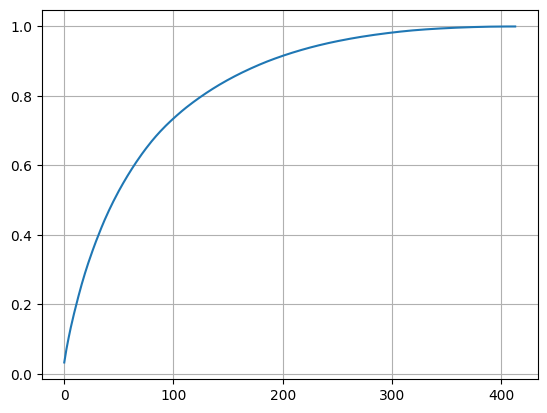

In [39]:
# cumulative explained variance
cumulative_explained_variance=np.cumsum(pca.explained_variance_ratio_)
#plot
plt.grid()
plt.plot(range(len(cumulative_explained_variance)),cumulative_explained_variance)


This chart is saying: To capture about 98% of the variance, we'd need to keep around 300 components.

We can confirm:

In [40]:
# How much variance we'd capture with the first 125 components
cumulative_explained_variance[300]

0.9824241831916605

Reducing 2574 features down to 300 (about 88% fewer features) while capturing almost 80% of the original variance is certainly not bad!

Initialize and fit another PCA transformation.
* This time, only keep 300 components.
* Generate the principal component features from the fitted instance and name the new matrix PC_items.
* Then, display the shape of PC_items to confirm it only has 300 features.

In [41]:
pca = PCA(n_components=300)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 300)

Next, for convenience, let's put PC_items into a new dataframe.

We'll also name the columns and update its index to be the same as the orginal item_data's index.

In [42]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424413,...,0.077310,-0.079686,0.013251,0.137724,-0.017650,0.003348,-0.042773,0.035262,-0.040718,-0.113852
12348,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,...,0.189959,0.359513,-0.060163,0.566640,0.162980,-0.388812,-0.922573,0.869794,-0.840495,-0.575829
12349,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,...,0.586434,-0.020880,0.226348,0.128409,0.221181,0.538011,-0.017862,-0.588228,0.022733,0.568727
12350,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,...,1.353102,0.550103,-0.166835,-0.179554,0.485504,0.639610,-1.646033,-1.671044,0.176314,0.986367
12352,-2.053113,2.110950,0.184807,0.128240,0.087787,-1.943579,2.383307,0.899610,-0.671980,0.081452,...,-0.212486,-0.364550,0.025492,-0.216141,-0.137631,-0.154079,0.132104,-0.085385,0.060135,-0.180109


* Now we have a dataframe of 300 customer-level principal component features.
* These were generated from the 300 principal components that explained the most variance for the original features.
* The index of this PCA item dataframe contains CustomerID's, which will make it possible for us to join this to our analytical base table.

Finally, save this item dataframe with PCA features as 'pca_item_data.csv'.
* Next, we'll compare the clusters made from using these features against those in 'threshold_item_data.csv'.
* Do not set index=None because we want to keep the CustomerID's as the index.

In [43]:
# Save pca_item_data.csv
items_pca.to_csv('/content/pca_item_data.csv')

# 9. KMeans Clustering
Let's import 3 CSV files we've saved throughout this project.
* Let's import 'analytical_base_table.csv' as base_df.
* Let's import 'threshold_item_data.csv' as threshold_item_data.
* Let's import 'pca_item_data.csv' as pca_item_data.
* Set index_col=0 for each one to use CustomerID as the index.

In [44]:
#import the analytical base table
base_df=pd.read_csv('/content/analytical_base_table.csv',index_col=0)
# import the threshold item features
threshold_item_data=pd.read_csv('/content/threshold_item_data.csv',index_col=0)
# import PCA item features
pca_item_data=pd.read_csv('/content/pca_item_data.csv',index_col=0)

In [45]:
# Print shape of each dataframe
print( base_df.shape )
print( threshold_item_data.shape )
print( pca_item_data.shape )

(414, 8)
(414, 20)
(414, 300)


Because K-Means creates clusters based on distances, and because distances are calculated by between observations defined by their feature values, **the features you choose to input into the algorithm heavily influence the clusters that are created.**

For this project, we will look at 3 possible feature sets and compare the clusters created from them. We'll try:
1. Only purchase pattern features ("Base DF")
2. Purchase pattern features + item features chosen by thresholding ("Threshold DF")
3. Purchase pattern features + principal component features from items ("PCA DF")

Create a threshold_df by joining base_df with threshold_item_data.

In [46]:
#join base_ddf with threshold_item_data
threshold_df=base_df.join(threshold_item_data)
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22961,22630,...,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,...,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,...,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,...,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,...,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,1,...,0,0,0,0,1,0,0,2,0,5


Create a pca_df by joining base_df with pca_item_data.

In [47]:
pca_df=base_df.join(pca_item_data)
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,...,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828917,...,0.077310,-0.079686,0.013251,0.137724,-0.017650,0.003348,-0.042773,0.035262,-0.040718,-0.113852
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226217,...,0.189959,0.359513,-0.060163,0.566640,0.162980,-0.388812,-0.922573,0.869794,-0.840495,-0.575829
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260847,2.387664,...,0.586434,-0.020880,0.226348,0.128409,0.221181,0.538011,-0.017862,-0.588228,0.022733,0.568727
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929320,-0.714859,...,1.353102,0.550103,-0.166835,-0.179554,0.485504,0.639610,-1.646033,-1.671044,0.176314,0.986367
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,-2.053113,2.110950,...,-0.212486,-0.364550,0.025492,-0.216141,-0.137631,-0.154079,0.132104,-0.085385,0.060135,-0.180109


### Number of clusters
So, how many clusters should you set?
* As with much of Unsupervised Learning, there's no right or wrong answer.
* Typically, you should consider how your client/key stakeholder will use the clusters.
* For example, let's say our client, the online gift retailer, employs 3 customer service reps, and they want to assign one cluster to each rep.
* In that case, the obvious answer is 3.
* For this project, we'll set the number of clusters to 3. However, you should always feel free to adapt this number depending on what you need.

First scale both the dataframes

In [48]:
# initialize instnace of StandardScaler
t_scaler=StandardScaler()
p_scaler=StandardScaler()
#fit and transform
threshold_df_scaled=t_scaler.fit_transform(threshold_df)
pca_df_scaled=p_scaler.fit_transform(pca_df)

K-Means with threshold_df

In [49]:
t_kmeans=KMeans(n_clusters=3,init='k-means++',random_state=123)

In [50]:
t_kmeans.fit(threshold_df_scaled)
threshold_df['cluster'] = t_kmeans.fit_predict(threshold_df_scaled)

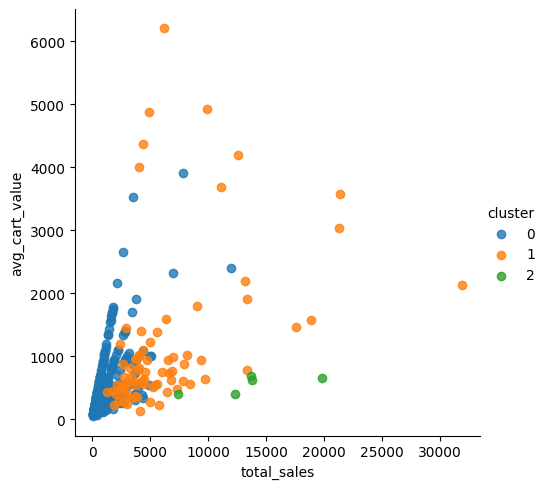

In [51]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

In [52]:
p_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [53]:
p_kmeans.fit(pca_df_scaled)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

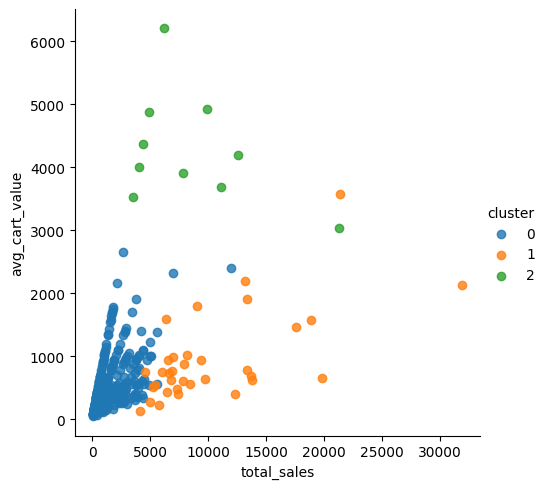

In [54]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

In [55]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.5228161936459332

Segmentation Insight: By comparing clusters from PCA and threshold methods, you can identify key segments within your customer base. For example:

Cluster 2 in the first plot (Green): This group appears to have higher avg_cart_value and total_sales, indicating high-value customers.
Cluster 0 and 1 (Blue and Orange): These could represent low to mid-value customers, with possible sub-segments based on behavior.